Regressions between ERA5 (dif. variables) and Cloud Index (CI) in Corrientes Argentina

Las anomalias de CI se generaron asi:

* Calculo el CI mensuales para los meses con menos del 20% de datos faltantes
* Calculo las anomalias de CI mensuales (le resto a las medias mensuales la CI climatologica de cada mes calculada sobre el periodo comun con el satelite: fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15")
* Todo se guarda en csvs: cada columna es una estacion. En: "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/paper"
TCC_monthly_CI_SMN_anomaly.csv

ERA5 is for southamerica

In [52]:
import os
import pandas as pd 
import datetime 
import numpy as np

import iris
#from iris.analysis import MEAN
#from iris.analysis.stats import pearsonr
import iris.coord_categorisation

import scipy
from scipy.stats import theilslopes #theil-sen trends
from iris.analysis.stats import pearsonr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import f_Iris
#import esmvalcore.preprocessor as ep 

In [2]:
# directories
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

#si estoy trabajando desde el servidor vegeta
ruta_a_archivos_ERA5_mensual = "/pikachu/datos/nadia.testani/Doctorado/datos/ERA5/mon/SAm" #ruta donde estan los archivos con datos de ERA5
ruta_a_archivos_CI = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/paper"
ruta_a_resultados = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2024" #ruta donde se guardan los resultados del analisis de nubosidad

Current working directory: /home/nadia.testani/Doctorado/DoctoradoCodigos/codigos2024


In [3]:
fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"

In [4]:
#Cloud Index
CI = pd.read_csv(f"{ruta_a_archivos_CI}/TCC_monthly_CI_SMN.csv") #from 1961-01-01 until 2021-11-01

#set dates as index
CI = CI.set_index(CI["Unnamed: 0"]) 
CI = CI.drop(["Unnamed: 0"], axis = 1)
CI.index = pd.DatetimeIndex(CI.index)

#estimate regional mean
CI_regional_mean = CI.mean(axis=1)

#filter theil-sen trend
def calculate_theilsen_slope(y):
    slope, intercept, _, _ = theilslopes(y, range(len(y)), alpha=0.95)
    return slope, intercept

CI_detrend = CI_regional_mean.copy()
trend = calculate_theilsen_slope(CI_detrend.values)[0] * np.arange(len(CI_detrend)) + calculate_theilsen_slope(CI_detrend.values)[1]
CI_detrend = CI_detrend - trend

#estimate climatology
CI_detrend_fechas_climatologia = CI_detrend.loc[fecha_inicio_climatologia_str:fecha_final_climatologia_str]
CI_detrend_climatologia = CI_detrend_fechas_climatologia.groupby(CI_detrend_fechas_climatologia.index.month).mean() 

#estimate anomalies
def f_serie_anomalias_mensuales(serie, serie_climatologia):
    serie_anomalia = serie.copy()
    for fecha in serie_anomalia.index:
        for mes in serie_anomalia.index.month.unique():
            if fecha.month == mes:
                serie_anomalia.loc[fecha] = serie.loc[fecha]-serie_climatologia.loc[mes]
    return serie_anomalia

CI_detrend_anom = f_serie_anomalias_mensuales(CI_detrend, CI_detrend_climatologia)

In [5]:
#ERA5
file_dir = ruta_a_archivos_ERA5_mensual
file_name = "new_data.nc"
variable_name = 't2m'
t2m = iris.load_cube(f"{file_dir}/{file_name}", variable_name) 
t2m = t2m[:,0,:,:] #select expver=1

In [6]:
#select dates common to CI 
date_i_CI = CI_detrend_anom.index[0]
date_f_CI = CI_detrend_anom.index[-1]

In [7]:
fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"
t2m_CIdates = f_Iris.clip_timerange(t2m, f"{str(date_i_CI)[0:10]}/{str(date_f_CI)[0:10]}")
#check that it is ok:
time_coord = t2m_CIdates.coord("time") 
time_axis = time_coord.units.num2date(time_coord.core_points())
#print(time_axis)

In [8]:
#detrend
t2m_CIdates_detrend = f_Iris.detrend_theil_sen_cube(t2m_CIdates, dimension='time', method='linear')

/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [42]:
#detrend
t2m_CIdates_detrend = f_Iris.detrend_theil_sen_cube(t2m_CIdates, dimension='time', method='linear')

/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [43]:
t2m_CIdates_detrend.data[:,5,6] #26 minutos

array([-1.91375919e+00, -1.18708582e+00, -6.20804639e-02,  1.49600499e+00,
        1.84638176e+00,  6.39026208e-01, -3.79333528e-01,  1.59615300e-02,
       -6.67417956e-02, -2.04533587e-01, -6.38108067e-01, -1.76325468e+00,
       -1.99596813e+00, -1.75068321e+00,  3.53201820e-01,  8.19688127e-01,
        5.91212245e-01,  6.77164377e-01, -2.89496953e-01,  5.84644004e-01,
        5.01940679e-01,  1.58202775e-01, -1.38137860e+00, -1.98106600e+00,
       -1.98834050e+00, -1.04470332e+00,  1.36238015e-01,  9.15457307e-01,
        8.45466704e-01,  1.16024785e+00,  2.90203215e-01,  6.66852946e-01,
        8.61286982e-01,  1.90408340e-01, -3.62665736e-01, -1.61493958e+00,
       -1.46033874e+00, -4.19237353e-01,  9.75277731e-01,  2.25283576e+00,
        3.04646281e+00,  9.11078480e-01,  2.66472799e-01,  7.22788927e-01,
        5.18890976e-01,  1.13284487e-01, -7.64387782e-01, -1.51832288e+00,
       -2.53414007e+00, -1.17945819e+00,  3.79262902e-02,  1.84179105e+00,
        2.26081653e+00,  

In [48]:
# anomalies
def anomalies_monthly(cube, reference_date_i, reference_date_f):
    """
    reference_date_i: str (e.g. "1983-12-15")
    reference_date_f: str (e.g. "2016-11-15")
    """
    #select temporal range for clim
    cube_clim = f_Iris.clip_timerange(cube, f"{str(date_i_CI)[0:10]}/{str(date_f_CI)[0:10]}")
    #Compute monthly climatology
    clim = cube_clim.aggregated_by('time.month', iris.analysis.MEAN)
    #Compute monthly anomalies 
    anom = cube.aggregated_by('time.month', iris.analysis.MEAN) - clim
    #Compute  anomalies 
    #Anom_month = anom.resample('time', iris.analysis.MEAN, freq='M')
    return anom  

fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"
t2m_CIdates_detrend_anom = anomalies_monthly(t2m_CIdates_detrend, fecha_inicio_climatologia_str, fecha_final_climatologia_str)

CoordinateNotFoundError: 'Expected to find exactly 1 time.month coordinate, but found none.'

In [13]:
t2m_CIdates_detrend_anom = f_Iris.anomalies(
    t2m_CIdates,
    period = "full",
    reference = f"{fecha_inicio_climatologia_str}/{fecha_final_climatologia_str}",
    standardize = False 
)

TypeError: f_Iris.extract_time() argument after ** must be a mapping, not str

In [50]:
CI_detrend_anom_cube = t2m_CIdates_detrend.copy()
CI_detrend_anom_cube = CI_detrend_anom_cube[:,1,1]
CI_detrend_anom_cube.data = CI_detrend_anom_cube

In [55]:
# regression ver
a, b = pearsonr(t2m_CIdates_detrend, t2m_CIdates_detrend)
plt.contourf(a.data)
#ver esto tambien

/home/nadia.testani/miniforge3/envs/base_nadia2/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/miniforge3/envs/base_nadia2/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/miniforge3/envs/base_nadia2/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/miniforge3/envs/base_nadia2/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/minifor

TypeError: Cube is not iterable

In [ ]:
# plot


In [ ]:
######## end ########

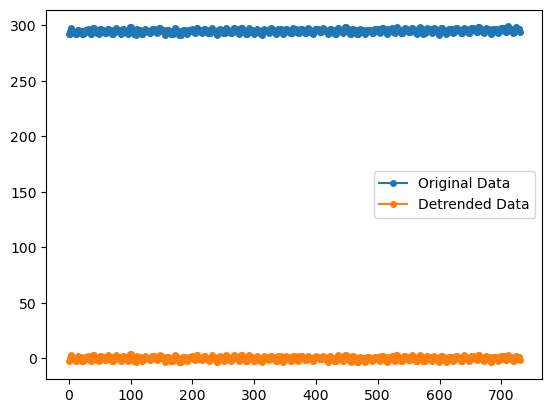

In [46]:
data = t2m_CIdates[:,1,1].data    
data = np.asarray(data)
dtype = 'd'
dshape = data.shape
axis = 0
N = dshape[axis]
bp = 0
bp = np.sort(np.unique(np.concatenate(np.atleast_1d(0, bp, N))))

# Restructure data so that the axis is along the first dimension
# and all other dimensions are collapsed into the second dimension
rnk = len(dshape)
newdata = np.moveaxis(data, axis, 0)
newdata_shape = newdata.shape
newdata = newdata.reshape(N, -1)

newdata = newdata.copy()  # make sure we have a copy

# Find Theil-Sen fit and remove it for each piece
# Calculate Theil-Sen fit and remove it for each piece
for m in range(len(bp) - 1):
    sl = range(bp[m], bp[m + 1])  # Convert slice to range
    x = np.arange(1, len(sl) + 1, dtype=dtype)
    y = newdata[sl]
    
    # Calculate Theil-Sen fit across all data points
    slopes = np.array([(y[j] - y[i]) / (x[j] - x[i]) for i in range(len(sl)-1) for j in range(i+1, len(sl))])
    median_slope = np.median(slopes)
    intercept = np.median(y - median_slope * x)
    
    # Calculate trend
    trend = median_slope * x + intercept
    
    # Remove trend from data
    newdata[sl] = y - trend.reshape(N, -1)


# Put data back in the original shape.
newdata = newdata.reshape(newdata_shape)
ret = np.moveaxis(newdata, 0, axis)

plt.plot(data, label='Original Data', marker='o', linestyle='-', markersize=4)
plt.plot(ret, label='Detrended Data', marker='o', linestyle='-', markersize=4)
plt.legend()
plt.show()


In [12]:
#Select times = times of climatology
#fecha_inicio_climatologia_str = "1983-12-15"
#fecha_final_climatologia_str = "2016-11-15"

time_coord = ERA5_netcdf_1.coord("time") 
time_axis = time_coord.units.num2date(time_coord.core_points())
timei = datetime.datetime(1983, 12, 1, 0, 0) 
timef = datetime.datetime(2016, 11, 1, 0, 0) 

# Create a constraint based on the chosen datetime
time_constraint = iris.Constraint(time=lambda cell: timei <= cell.point <= timef)

# Apply the constraint to slice the cube
ERA5_netcdf_1_datesClimatology = ERA5_netcdf_1.extract(time_constraint)

time_coord = ERA5_netcdf_1_datesClimatology.coord("time")
time_axis = time_coord.units.num2date(time_coord.core_points())

#mean values
# calculate monthly mean
# Categorize the time coordinate by month
iris.coord_categorisation.add_month(ERA5_netcdf_1_datesClimatology, 'time', name='month')

# Calculate the monthly mean for each grid point
monthly_means = ERA5_netcdf_1_datesClimatology.aggregated_by('month', iris.analysis.MEAN)

In [62]:
# Filter monthly means --> anomalies
monthly_means_array = np.repeat(monthly_means.data, len(data_trend_filtered_datesCI.data[:,1,1])/12, axis=0)
ERA5_trend_filtered_anomalies = data_trend_filtered_datesCI.data - monthly_means_array

#I have to delete the last december to calculate the regression

/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
ERA5_netcdf_detrend

<iris 'Cube' of 2 metre temperature / (K) (time: 768; latitude: 301; longitude: 217)>